<a href="https://colab.research.google.com/github/hepham/GANS/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import pickle as pkl
import time
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
mb_size = 100

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=mb_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=mb_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [3]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [4]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [5]:
G


Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [8]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [7]:
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)


In [6]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(mb_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(mb_size, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(mb_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY Dicrimination
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [9]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(mb_size, z_dim).to(device))
    
    y = Variable(torch.ones(mb_size, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
G.load_state_dict(torch.load('/content/drive/MyDrive/model/Generator.pt'))
D.load_state_dict(torch.load('/content/drive/MyDrive/model/Dicriminator.pt'))

In [12]:
n_epoch = 100
losses=[]
min =10
start_time = time.time()
for epoch in range(0, n_epoch):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))
        
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
    
    dloss=torch.mean(torch.FloatTensor(D_losses)).numpy()
    gloss=torch.mean(torch.FloatTensor(G_losses)).numpy()
    if(abs(gloss-dloss)<min):
      min=abs(gloss-dloss)
      torch.save(G.state_dict(), '/content/drive/MyDrive/model/Generator.pt')
      torch.save(D.state_dict(), '/content/drive/MyDrive/model/Dicriminator.pt')
    losses.append((dloss,gloss)) 
    end_time = time.time()
print('Training process done! Time used: {} mins.'.format((end_time - start_time)/60))

[0/100]: loss_d: 0.844, loss_g: 3.225
[1/100]: loss_d: 0.756, loss_g: 2.368
[2/100]: loss_d: 0.564, loss_g: 3.179
[3/100]: loss_d: 0.396, loss_g: 3.270
[4/100]: loss_d: 0.379, loss_g: 3.786
[5/100]: loss_d: 0.443, loss_g: 3.283
[6/100]: loss_d: 0.476, loss_g: 3.011
[7/100]: loss_d: 0.580, loss_g: 2.733
[8/100]: loss_d: 0.617, loss_g: 2.403
[9/100]: loss_d: 0.741, loss_g: 2.095
[10/100]: loss_d: 0.727, loss_g: 2.097
[11/100]: loss_d: 0.723, loss_g: 2.036
[12/100]: loss_d: 0.744, loss_g: 2.039
[13/100]: loss_d: 0.855, loss_g: 1.738
[14/100]: loss_d: 0.779, loss_g: 2.053
[15/100]: loss_d: 0.769, loss_g: 1.992
[16/100]: loss_d: 0.840, loss_g: 1.802
[17/100]: loss_d: 0.837, loss_g: 1.805
[18/100]: loss_d: 0.822, loss_g: 1.820
[19/100]: loss_d: 0.873, loss_g: 1.650
[20/100]: loss_d: 0.893, loss_g: 1.674
[21/100]: loss_d: 0.931, loss_g: 1.542
[22/100]: loss_d: 1.002, loss_g: 1.403
[23/100]: loss_d: 0.964, loss_g: 1.470
[24/100]: loss_d: 0.978, loss_g: 1.449
[25/100]: loss_d: 0.972, loss_g: 1.

In [13]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

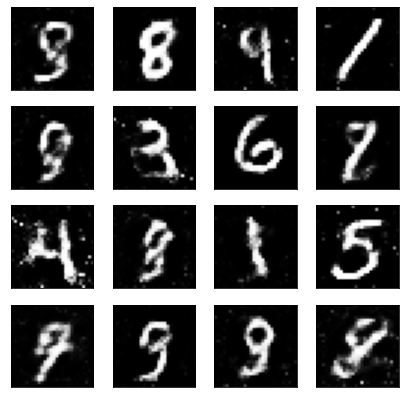

In [14]:
with torch.no_grad():
    test_z = Variable(torch.randn(mb_size, z_dim).to(device))
    generated = G(test_z)
    sample_size=16
    rand_z = np.random.uniform(-1, 1, size=(sample_size, 100))
    rand_z = torch.from_numpy(rand_z).float()

    G.eval() # eval mode
    # generated samples
    rand_images = G(rand_z)
    view_samples(0, [rand_images])
    save_image(generated.view(generated.size(0), 1, 28, 28), '/content/drive/MyDrive/model/sample_' + '.png')


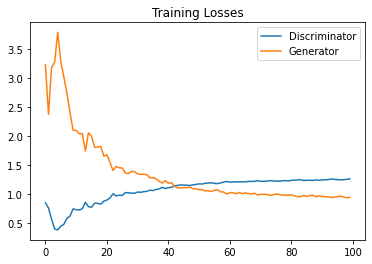

In [15]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')